# Fitting truncated Gaussians

In [1]:
from scipy import stats
import scipy.sparse
import numpy as np
import maxentropy
import maxentropy.skmaxent
import maxentropy.maxentutils

In [2]:
whichplot = 2  # sub-plot in Figure 6.1 (0 , 1 , or 2)
d = 1     # number of dimensions
m = d*3   # number of features

In [3]:
# Bounds
o = np.ones(d)
if whichplot == 0:
    lower = -2.5 * o
    upper = -lower
elif whichplot == 1:
    lower = 0.5 * o
    upper = 2.5 * o
elif whichplot == 2:
    lower = -0.1 * o
    upper = 0.1 * o

In [4]:
def f0(x):
    return x

In [5]:
def f1(x):
    return x**2

In [6]:
def f2(x):
    return (lower < x) & (x < upper)

In [7]:
f = [f0, f1, f2]

In [8]:
# Target constraint values
b = np.empty (m , float )
if whichplot == 0:
    b [0: m :3] = 0   # expectation
    b [1: m :3] = 1   # second moment
    b [2: m :3] = 1   # truncate completely outside bounds
elif whichplot == 1:
    b [0: m :3] = 1.0 # expectation
    b [1: m :3] = 1.2 # second moment
    b [2: m :3] = 1   # truncate completely outside bounds
elif whichplot == 2:
    b [:] = [0. , 0.0033 , 1]

In [9]:
b

array([ 0.    ,  0.0033,  1.    ])

Create a generator of features of random points under a Gaussian auxiliary dist $q$ with diagonal covariance matrix.

In [10]:
from scipy.stats import norm

In [11]:
mu = b[0]
sigma = (b[1] - mu**2)**0.5
mu, sigma

(0.0, 0.057445626465380289)

In [12]:
auxiliary = stats.norm(loc=mu, scale=sigma)

In [13]:
auxiliary

In [14]:
from maxentropy.maxentutils import auxiliary_sampler_scipy

In [15]:
sampler = auxiliary_sampler_scipy(auxiliary, n=10**5)

In [16]:
xs, log_q_xs = sampler()

In [17]:
xs.shape, log_q_xs.shape

((100000, 1), (100000,))

In [18]:
xs

array([[-0.01446412],
       [-0.03827211],
       [ 0.06137026],
       ..., 
       [-0.04039651],
       [-0.02151893],
       [-0.05684065]])

In [19]:
xs[:10, 0]

array([-0.01446412, -0.03827211,  0.06137026, -0.14243812, -0.02791961,
       -0.0729012 ,  0.0307606 , -0.0788735 ,  0.01885368, -0.00275835])

We pass `features` as a vectorized function that operates on each vector of samples xs = `[x_1,...,x_n]`.

In [20]:
f

[<function __main__.f0>, <function __main__.f1>, <function __main__.f2>]

We pass `auxiliary_sampler` as a generator function that will be used for importance sampling. This yields a tuple `(log_q_xs, xs)` whose dimensions are `(n,)` and `(d, n)`.

In [21]:
b

array([ 0.    ,  0.0033,  1.    ])

In [22]:
model = maxentropy.skmaxent.MCMinDivergenceModel(f, sampler)   # create a model

In [23]:
k = np.reshape(b, (1, -1))
k.shape

(1, 3)

In [24]:
model.fit(k)

MCMinDivergenceModel(algorithm='CG',
           auxiliary_sampler=<function auxiliary_sampler_scipy.<locals>.sampler at 0x1186c8d08>,
           feature_functions=None, matrix_format='csc_matrix',
           prior_log_probs=None, vectorized=None, verbose=0)

In [25]:
model.expectations()

array([  5.26865049e-08,   3.30006805e-03,   9.99999975e-01])

In [26]:
np.allclose(model.expectations(), k)

False

In [27]:
model.iters, model.fnevals

(19, 144)

After running this code, the `model` has a vector
of parameters $\theta = (\theta_i)^{3d}_{i=1}$
stored as the array `model.params`. The pdf of the fitted model can then be retrieved
with the `model.pdf` method and plotted as follows:



In [28]:
%matplotlib inline

In [29]:
lower, upper

(array([-0.1]), array([ 0.1]))

In [30]:
# Plot the marginal pdf in dimension 1, letting x_d =0
# for all other dimensions d.
xs = np.arange(lower[0], upper[0], (upper[0] - lower[0]) / 100.)
all_xs = np.zeros((len(xs), d), float)
all_xs[:, 0] = xs

In [31]:
all_xs.shape

(100, 1)

In [32]:
model.features(xs)

<3x100 sparse matrix of type '<class 'numpy.float64'>'
	with 299 stored elements in Compressed Sparse Column format>

In [33]:
pdf = model.pdf(model.features(all_xs))

In [34]:
xs.shape

(100,)

(0, 5.5551488807629372)

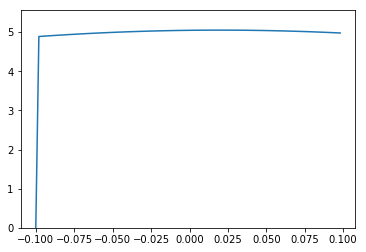

In [35]:
import matplotlib.pyplot as plt
plt.plot(xs, pdf)
plt.ylim(0, pdf.max()*1.1)

In [36]:
model.expectations()

array([  5.26865049e-08,   3.30006805e-03,   9.99999975e-01])

In [37]:
b

array([ 0.    ,  0.0033,  1.    ])

In [38]:
np.allclose(model.expectations(), b, atol=1e-6)

True